In [1]:
# Import packages
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Dataset2: Boston Housing Dataset 

In [24]:
print("1. Load the dataset")
house_data = pd.read_csv('./housing_data.csv', header = None)
x = house_data.iloc[:,0:13].values        # Feature variables
y = house_data.iloc[:,13].values          # Target variables
feature = ['Constant','CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
print("done")

1. Load the dataset
done


In [25]:
def significanceAnalysis(model, feature, x, y) :
    model.fit(x,y)
    params = np.append(model.intercept_,model.coef_)
    newX = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
    MSE = mean_squared_error(y,model.predict(x))
    standard_error = np.sqrt(MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal()))
    t_values = params/standard_error
    p_values =[2*(1-stats.t.cdf(np.abs(i),len(x))) for i in t_values]

    analyzer = pd.DataFrame()
    analyzer["Coefficients"],analyzer["Standard Errors"],analyzer["t values"],analyzer["p values"] = \
        [params,standard_error,t_values,p_values]
    analyzer.index = feature
    return analyzer


In [26]:
print("Feature analysis")
lr = LinearRegression(fit_intercept=True, n_jobs = 2)  # Linear Regression Model

# Analyze the significance of different variables
print("---------------Signifiance of different variables---------------")
lrAnalysis = significanceAnalysis(lr,feature,x,y)
lrCoeff = lrAnalysis.iloc[:,0].values
print(lrAnalysis)
print(" ")

Feature analysis
---------------Signifiance of different variables---------------
          Coefficients  Standard Errors   t values      p values
Constant     36.459488         5.032362   7.245005  1.623146e-12
CRIM         -0.108011         0.032407  -3.332948  9.222325e-04
ZN            0.046420         0.013536   3.429351  6.544318e-04
INDUS         0.020559         0.060639   0.339033  7.347254e-01
CHAS          2.686734         0.849577   3.162437  1.658464e-03
NOX         -17.766611         3.766531  -4.716970  3.100926e-06
RM            3.809865         0.412103   9.244932  0.000000e+00
AGE           0.000692         0.013026   0.053143  9.576391e-01
DIS          -1.475567         0.196676  -7.502521  2.835510e-13
RAD           0.306049         0.065422   4.678070  3.721444e-06
TAX          -0.012335         0.003708  -3.326349  9.438660e-04
PTRATIO      -0.952747         0.129004  -7.385397  6.306067e-13
B             0.009312         0.002649   3.515771  4.778828e-04
LSTAT   

The most significant features: 'RM', 'LSTAT', 'DIS', 'PTRATIO'

The lest significant features: 'INDUS', 'AGE'

# Linear Regression

10 fold cross validation

The RMSE of test is the following: 
[3.0474492130107302, 3.7618191292922147, 3.7514805283473454, 5.933542308423677, 5.646690771105232, 4.453748753783686, 3.153929165643732, 12.975953897200196, 5.773191930599295, 3.31065109599648]
The average RMSE of test is 5.18

The RMSE of train is the following: 
[4.8335523617121865, 4.783516940852941, 4.818306233036741, 4.557598345146193, 4.619028719706438, 4.729027367770045, 4.829826233518953, 3.4582072500374736, 4.646105398797536, 4.8155003289057445]
The average RMSE of train is 4.61

The following two plots using the whole dataset


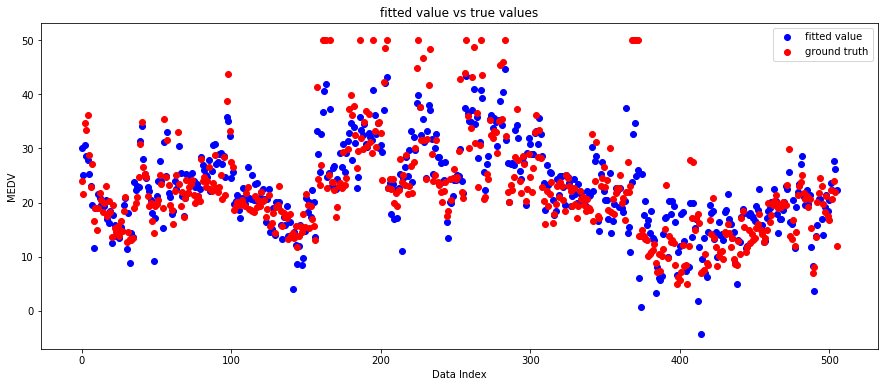

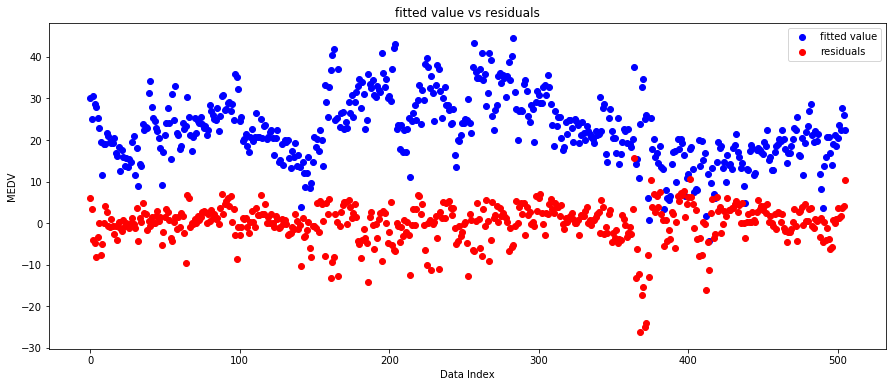

In [5]:
print("10 fold cross validation\n")
# 10 fold cross validation
kf = KFold(n_splits=10, shuffle=False, random_state=None)
rmse_test, rmse_train = [],[]
for trainIndex, testIndex in kf.split(house_data) :
    x_train,x_test = x[trainIndex], x[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    lr.fit(x_train,y_train)
    rmse_test.append(np.sqrt(mean_squared_error(y_test,lr.predict(x_test))))
    rmse_train.append(np.sqrt(mean_squared_error(y_train,lr.predict(x_train))))


print("The RMSE of test is the following: ")
print(rmse_test)
print("The average RMSE of test is %.2f" % np.mean(rmse_test))
print("\nThe RMSE of train is the following: ")
print(rmse_train)
print("The average RMSE of train is %.2f" % np.mean(rmse_train))

# Whole dataset 
print("\nThe following two plots using the whole dataset")
predictions, ground_truth = [],[]
xWhole = lr.fit(x,y).predict(x)
predictions.extend(xWhole.tolist())
ground_truth.extend(y)

# Plot 1: fitted values vs true values
fig = plt.figure(figsize=(15,6))   
index = range(0, 506)
plt.scatter(index, predictions, label='fitted value', c = 'b')
plt.scatter(index, ground_truth, label='ground truth', c = 'r')
plt.legend()
plt.ylabel("MEDV")
plt.xlabel('Data Index')
plt.title("fitted value vs true values")
plt.show()    
# Plot 2 : residuals vs fitted values
residuals = [i-j for i, j in zip(predictions, ground_truth)]
fig = plt.figure(figsize=(15,6))   
plt.scatter(index, predictions, label='fitted value', c = 'b')
plt.scatter(index, residuals, label='residuals', c = 'r')
plt.legend()
plt.ylabel("MEDV")
plt.xlabel('Data Index')
plt.title("fitted value vs residuals")
plt.show() 

# Ridge Regularizer

In [6]:
avg_rmse_test, avg_rmse_train = [], []
alpha = []
for a in np.arange(0.1,60,0.1):
    ridge = Ridge(alpha=a)
    # 10 fold cross validation
    kf = KFold(n_splits=10, shuffle=False, random_state=None)
    rmse_test, rmse_train = [],[]
    for trainIndex, testIndex in kf.split(house_data) :
        x_train,x_test = x[trainIndex], x[testIndex]
        y_train, y_test = y[trainIndex], y[testIndex]
        ridge.fit(x_train,y_train)
        rmse_test.append(np.sqrt(mean_squared_error(y_test,ridge.predict(x_test))))
        rmse_train.append(np.sqrt(mean_squared_error(y_train,ridge.predict(x_train))))
    avg_rmse_test.append(np.mean(rmse_test))
    avg_rmse_train.append(np.mean(rmse_train))
    alpha.append(a)

print("The best alpha is %f\n" % alpha[avg_rmse_test.index(min(avg_rmse_test))])

# 10 fold cross validation with best alpha
kf = KFold(n_splits=10)
rmse_test, rmse_train = [],[]
ridge = Ridge(alpha = alpha[avg_rmse_test.index(min(avg_rmse_test))])
print("---------------Signifiance of different variables---------------")
ridgeAnalysis = significanceAnalysis(ridge, feature, x, y)
ridgeCoeff = ridgeAnalysis.iloc[:,0].values
print(ridgeAnalysis) 
for trainIndex, testIndex in kf.split(house_data) :
    x_train,x_test = x[trainIndex], x[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    ridge.fit(x_train,y_train)
    rmse_test.append(np.sqrt(mean_squared_error(y_test,ridge.predict(x_test).tolist())))
    rmse_train.append(np.sqrt(mean_squared_error(y_train,ridge.predict(x_train).tolist())))

print("\nrmse of test with the best alpha: ")
print(rmse_test)
print("The best average RMSE of test is %f" % np.mean(rmse_test))
print("\nrmse of train with the best alpha: ")
print(rmse_train)
print("The best average RMSE of test is %f" % np.mean(rmse_train))

The best alpha is 51.900000

---------------Signifiance of different variables---------------
          Coefficients  Standard Errors   t values      p values
Constant     32.460749         5.188590   6.256179  8.409260e-10
CRIM         -0.102280         0.033413  -3.061058  2.322748e-03
ZN            0.052867         0.013956   3.787990  1.701261e-04
INDUS        -0.051070         0.062522  -0.816842  4.144029e-01
CHAS          0.984005         0.875952   1.123355  2.618195e-01
NOX          -0.508607         3.883461  -0.130967  8.958531e-01
RM            2.906896         0.424897   6.841418  2.271783e-11
AGE          -0.004539         0.013430  -0.337958  7.355353e-01
DIS          -1.199220         0.202782  -5.913840  6.156410e-09
RAD           0.301378         0.067453   4.467960  9.750616e-06
TAX          -0.015243         0.003823  -3.986795  7.683647e-05
PTRATIO      -0.816047         0.133009  -6.135270  1.716483e-09
B             0.009728         0.002731   3.562462  4.021375e

# Lasso Regularizer

In [7]:
avg_rmse_test, avg_rmse_train = [], []
alpha = []
for a in np.arange(0.001,0.5,0.001):
    lasso = Lasso(alpha=a)
    # 10 fold cross validation
    kf = KFold(n_splits=10)
    rmse_test, rmse_train = [],[]
    for trainIndex, testIndex in kf.split(house_data) :
        x_train,x_test = x[trainIndex], x[testIndex]
        y_train, y_test = y[trainIndex], y[testIndex]
        lasso.fit(x_train,y_train)
        rmse_test.append(np.sqrt(mean_squared_error(y_test,lasso.predict(x_test).tolist())))
        rmse_train.append(np.sqrt(mean_squared_error(y_train,lasso.predict(x_train).tolist())))
    avg_rmse_test.append(np.mean(rmse_test))
    avg_rmse_train.append(np.mean(rmse_train))
    alpha.append(a)

print("The best alpha is %f" % alpha[avg_rmse_test.index(min(avg_rmse_test))])

# 10 fold cross validation with best alpha
kf = KFold(n_splits=10)
rmse_test, rmse_train = [],[]
lasso = Lasso(alpha = alpha[avg_rmse_test.index(min(avg_rmse_test))])
print("---------------Signifiance of different variables---------------")
lassoAnalysis = significanceAnalysis(lasso, feature, x, y)
lassoCoeff = lassoAnalysis.iloc[:,0].values
print(lassoAnalysis) 
for trainIndex, testIndex in kf.split(house_data) :
    x_train,x_test = x[trainIndex], x[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    lasso.fit(x_train,y_train)
    rmse_test.append(np.sqrt(mean_squared_error(y_test,lasso.predict(x_test))))
    rmse_train.append(np.sqrt(mean_squared_error(y_train,lasso.predict(x_train))))

print("\nrmse of test with the best alpha: ")
print(rmse_test)
print("The best average RMSE of test is %f" % np.mean(rmse_test))
print("\nrmse of train with the best alpha: ")
print(rmse_train)
print("The best average RMSE of test is %f" % np.mean(rmse_train))

The best alpha is 0.030000
---------------Signifiance of different variables---------------
          Coefficients  Standard Errors   t values      p values
Constant     29.764659         5.069475   5.871349  7.831714e-09
CRIM         -0.102566         0.032646  -3.141750  1.777772e-03
ZN            0.047863         0.013636   3.510057  4.880187e-04
INDUS        -0.016592         0.061086  -0.271608  7.860339e-01
CHAS          2.131692         0.855843   2.490753  1.306681e-02
NOX          -7.733933         3.794308  -2.038299  4.203948e-02
RM            3.825939         0.415142   9.215970  0.000000e+00
AGE          -0.006839         0.013122  -0.521159  6.024840e-01
DIS          -1.311850         0.198127  -6.621272  9.109735e-11
RAD           0.285037         0.065905   4.324987  1.838221e-05
TAX          -0.013351         0.003735  -3.573960  3.852928e-04
PTRATIO      -0.845025         0.129956  -6.502413  1.899256e-10
B             0.009840         0.002668   3.688211  2.502810e-0

# Elastic Net Regularizer

In [8]:
avg_rmse_test, avg_rmse_train = [], []
alpha, l1_ratio = [], []
for a in np.arange(0.01,2,0.05):
    for l1 in np.arange(0.02,1,0.01) :
        en = ElasticNet(alpha=a, l1_ratio=l1)
        # 10 fold cross validation
        kf = KFold(n_splits=10)
        rmse_test, rmse_train = [],[]
        for trainIndex, testIndex in kf.split(house_data) :
            x_train,x_test = x[trainIndex], x[testIndex]
            y_train, y_test = y[trainIndex], y[testIndex]
            en.fit(x_train,y_train)
            rmse_test.append(np.sqrt(mean_squared_error(y_test,en.predict(x_test))))
            rmse_train.append(np.sqrt(mean_squared_error(y_train,en.predict(x_train))))
        avg_rmse_test.append(np.mean(rmse_test))
        avg_rmse_train.append(np.mean(rmse_train))
        alpha.append(a)
        l1_ratio.append(l1)

print("The best alpha is %f and the best l1 ratio is %f" \
      % (alpha[avg_rmse_test.index(min(avg_rmse_test))], l1_ratio[avg_rmse_test.index(min(avg_rmse_test))]))
       
# 10 fold cross validation with best alpha
kf = KFold(n_splits=10)
rmse_test, rmse_train = [],[]
en = ElasticNet(alpha = \
                alpha[avg_rmse_test.index(min(avg_rmse_test))], l1_ratio = l1_ratio[avg_rmse_test.index(min(avg_rmse_test))])
print("---------------Signifiance of different variables---------------")
enAnalysis = significanceAnalysis(en, feature, x, y)
enCoeff = enAnalysis.iloc[:,0].values
print(enAnalysis) 
for trainIndex, testIndex in kf.split(house_data) :
    x_train,x_test = x[trainIndex], x[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    en.fit(x_train,y_train)
    rmse_test.append(np.sqrt(mean_squared_error(y_test,en.predict(x_test))))
    rmse_train.append(np.sqrt(mean_squared_error(y_train,en.predict(x_train))))

print("\nrmse of test with the best alpha: ")
print(rmse_test)
print("The best average RMSE of test is %f" % np.mean(rmse_test))
print("\nrmse of train with the best alpha: ")
print(rmse_train)
print("The best average RMSE of test is %f" % np.mean(rmse_train))

The best alpha is 0.110000 and the best l1 ratio is 0.020000
---------------Signifiance of different variables---------------
          Coefficients  Standard Errors   t values      p values
Constant     32.743878         5.193062   6.305313  6.272345e-10
CRIM         -0.102221         0.033442  -3.056676  2.356338e-03
ZN            0.052998         0.013968   3.794105  1.661017e-04
INDUS        -0.051091         0.062575  -0.816473  4.146140e-01
CHAS          0.942272         0.876707   1.074785  2.829831e-01
NOX          -0.464066         3.886808  -0.119395  9.050097e-01
RM            2.863268         0.425263   6.732937  4.524159e-11
AGE          -0.004103         0.013442  -0.305272  7.602848e-01
DIS          -1.195236         0.202957  -5.889120  7.082964e-09
RAD           0.302381         0.067511   4.478962  9.279574e-06
TAX          -0.015297         0.003827  -3.997595  7.351730e-05
PTRATIO      -0.816897         0.133124  -6.136377  1.705392e-09
B             0.009706       

# Coefficient Comparsion

In [9]:
allCoeff= pd.DataFrame()
allCoeff["Linear Regression"],allCoeff["Ridge"],allCoeff["Lasso"],allCoeff["Elastic Net"] = \
    [lrCoeff,ridgeCoeff,lassoCoeff,enCoeff]
allCoeff.index = feature
print(allCoeff)

          Linear Regression      Ridge      Lasso  Elastic Net
Constant          36.459488  32.460749  29.764659    32.743878
CRIM              -0.108011  -0.102280  -0.102566    -0.102221
ZN                 0.046420   0.052867   0.047863     0.052998
INDUS              0.020559  -0.051070  -0.016592    -0.051091
CHAS               2.686734   0.984005   2.131692     0.942272
NOX              -17.766611  -0.508607  -7.733933    -0.464066
RM                 3.809865   2.906896   3.825939     2.863268
AGE                0.000692  -0.004539  -0.006839    -0.004103
DIS               -1.475567  -1.199220  -1.311850    -1.195236
RAD                0.306049   0.301378   0.285037     0.302381
TAX               -0.012335  -0.015243  -0.013351    -0.015297
PTRATIO           -0.952747  -0.816047  -0.845025    -0.816897
B                  0.009312   0.009728   0.009840     0.009706
LSTAT             -0.524758  -0.620196  -0.542254    -0.623424


# Dataset3: Car Insurance Dataset

In [11]:
# load data
insurance_df_raw = pd.read_csv('insurance_data.csv')

# transfer the raw dataframe to a dataframe that we can use OneHotEncoder 
ft4_dict = {'female':0, 'male':1}
ft5_dict = {'yes':0, 'no':1}
ft6_dict = {'southeast':0, 'southwest':1, 'northeast':2, 'northwest':3}     
insurance_df = insurance_df_raw.replace({'ft4': ft4_dict, 'ft5':ft5_dict,'ft6': ft6_dict})

# name of features
col_name = list(insurance_df.columns.values)

# get the values for features and target
n_row,n_cols = insurance_df.shape
X = insurance_df.iloc[:,0:n_cols-1].values
y = insurance_df.iloc[:,n_cols-1].values

In [12]:
###  some functions

# define a k-fold cross validation function and return the train_rmse and the test_rmse
def k_fold_cv_rmse(model,k,X,y):
    kf = KFold(n_splits=k, shuffle=False, random_state=None)
    train_rmse_list = []
    test_rmse_list = []
    for train_index, test_index in kf.split(X):                 
        X_train, y_train = X[train_index], y[train_index]           # training data
        X_test, y_test = X[test_index], y[test_index]               # testing data
        model.fit(X_train,y_train)                                  # train a model with the training data
        y_train_pred = model.predict(X_train)                       # use the model we trained to predict y for training data
        y_test_pred = model.predict(X_test)                            # use the model we trained to predict y for testing data
        train_rmse = np.sqrt(np.mean(np.square(y_train_pred - y_train)))     # train_rmse 
        test_rmse = np.sqrt(np.mean(np.square(y_test_pred - y_test)))        # test_rmse
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
    mean_train_rmse = np.mean(train_rmse_list)
    mean_test_rmse = np.mean(test_rmse_list)
    print('RMSE for training data is: ', mean_train_rmse)
    print('RMSE for testing data is: ', mean_test_rmse) 
    return mean_train_rmse, mean_test_rmse

# define a function to plot true values & fitted values, fitted values & residuals
def plot_target_val_and_residual(y,y_pred):
    # plot true values and fitted values
    plt.figure()
    plt.scatter(range(len(y_pred)), y_pred, marker='.', c='r', label='fitted values')
    plt.scatter(range(len(y)), y, marker='.', c='b', label='true values')
    plt.xlabel('data index')
    plt.ylabel('target values')
    plt.legend()
    plt.title('fitted values against true values')
    # plot residuals and fitted values
    plt.figure()
    plt.scatter(range(len(y_pred)) ,(y - y_pred), marker='.', c='g', label='residuals')
    plt.scatter(range(len(y)), y_pred, marker='.', c='r', label='fitted values')
    plt.xlabel('data index')
    plt.ylabel('fitted values & residuals')
    plt.legend()
    plt.title('residuals against fitted values')

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


RMSE for training data is:  6039.342370581926
RMSE for testing data is:  6063.643882478563


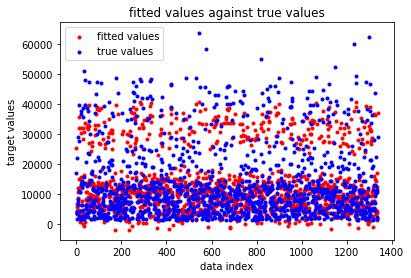

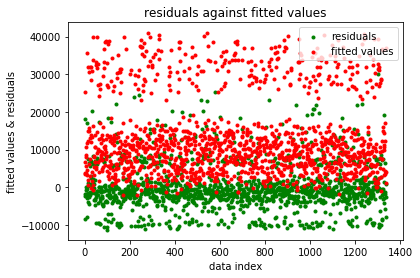

In [13]:
### 1(a)

# use OneHotEncoder to do one hot encoding for X
enc = OneHotEncoder(n_values='auto', categorical_features=[3,4,5], sparse=False, handle_unknown='error')
X_enc1 = enc.fit_transform(X)


# define a linear model and do the cross validation, report RMSE for training data and testing data
linear_model = LinearRegression(fit_intercept=True)
#mse_cv1 = cross_validate(linear_model, X_enc1, y, return_train_score=True, scoring='neg_mean_squared_error')
train_rmse1, test_rmse1 = k_fold_cv_rmse(linear_model,10,X_enc1,y)
     
# train a linear model and use it to predict
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_enc1,y)
y_pred1 = linear_model.predict(X_enc1)


# plot fitted values against true values as scatter plots using the whole dataset
# Plot residuals versus fitted values as scatter plots using the whole dataset
plot_target_val_and_residual(y,y_pred1)

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


RMSE for training data is:  6039.250426233231
RMSE for testing data is:  6062.636312256011


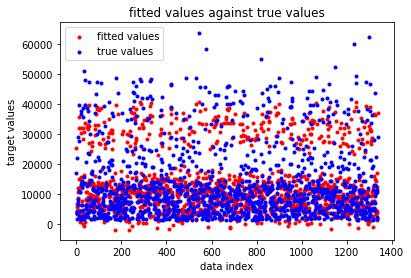

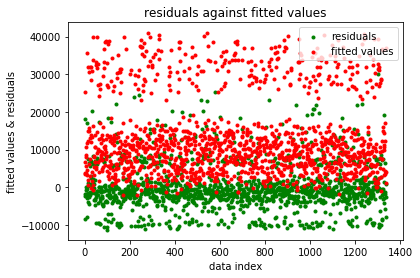

In [14]:
### 1(b)

#Standardize all these numerical features and keep the one-hot-encoded features
X_standardized = X
X_standardized[:,0:3] = scale(X_standardized[:,0:3], axis=0, with_mean=True, with_std=True,copy=True)    # standarize numerical features
enc = OneHotEncoder(n_values='auto', categorical_features=[3,4,5], sparse=False, handle_unknown='error')  
X_enc2 = enc.fit_transform(X_standardized)           # encode categorical features

# define a linear model and do the cross validation, report RMSE for training data and testing data
linear_model = LinearRegression(fit_intercept=True)
train_rmse2, test_rmse2 = k_fold_cv_rmse(linear_model,10,X_enc2,y)

# train a linear model and use it to predict
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_enc2,y)
y_pred2 = linear_model.predict(X_enc2)


# plot fitted values against true values as scatter plots using the whole dataset
# Plot residuals versus fitted values as scatter plots using the whole dataset
plot_target_val_and_residual(y,y_pred1)

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


RMSE for training data is:  6198.508413104524
RMSE for testing data is:  6221.0843850934525


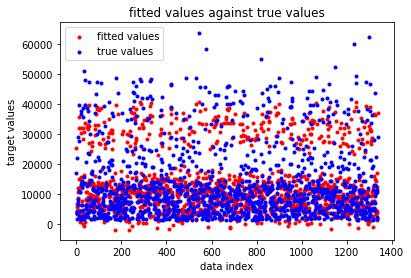

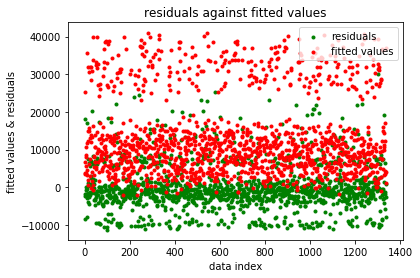

In [15]:
### 1(c)
# get the values for features and target
n_row,n_cols = insurance_df.shape
X = insurance_df.iloc[:,0:n_cols-1].values
y = insurance_df.iloc[:,n_cols-1].values

# redefine ft1           
for i in range(len(X[:,0])):
    if X[i,0]<30:
        X[i,0] = 1                     #X[:,0][X[:,0]<30] = 1
    elif X[i,0]>=30 and X[i,0]<=50:
        X[i,0] = 2
    else:
        X[i,0] = 3

# standardize ft2,ft3 and perform OneHotEncoder to ft4,ft5.ft6
X_standardized = X
X_standardized[:,1:3] = scale(X_standardized[:,1:3], axis=0, with_mean=True, with_std=True,copy=True)    # standarize numerical features
enc = OneHotEncoder(n_values='auto', categorical_features=[3,4,5], sparse=False, handle_unknown='error')  
X_enc3 = enc.fit_transform(X_standardized)           # encode categorical features


# define a linear model and do the cross validation, report RMSE for training data and testing data
linear_model = LinearRegression(fit_intercept=True)
train_rmse3, test_rmse3 = k_fold_cv_rmse(linear_model,10,X_enc3,y)
      


# train a linear model and use it to predict
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_enc3,y)
y_pred3 = linear_model.predict(X_enc3)


# plot fitted values against true values as scatter plots using the whole dataset
# Plot residuals versus fitted values as scatter plots using the whole dataset
plot_target_val_and_residual(y,y_pred1)

[1868.35109234 1726.07411819  524.29453691  586.80312699  284.25189929
  610.77704565] [3.95160002e-256 6.10442144e-243 3.63529334e-098 8.98169775e-108
 5.61231739e-058 2.24789404e-111]
the best two features for f_regression is: ft1 and ft2 
[1.49984053 0.07283945 0.16156756 0.17665987 0.36917105 0.0758473 ]
the best two features for mutual_info_regression is: ft1 and ft5 


Text(0.5, 1.0, 'charges vs. ft1')

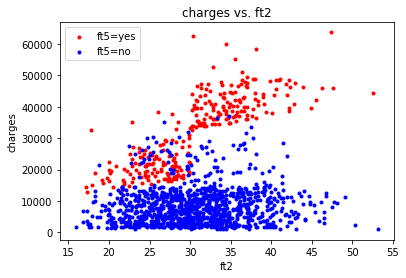

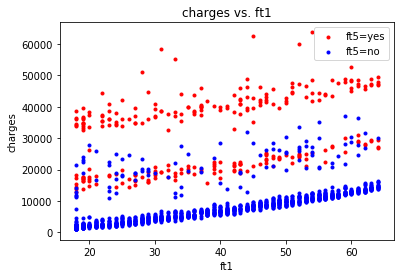

In [16]:
### 2
# get the values for features and target
n_row,n_cols = insurance_df.shape
X = insurance_df.iloc[:,0:n_cols-1].values  # do not need to do one hot encoding
y = insurance_df.iloc[:,n_cols-1].values

# name of features
col_name = list(insurance_df.columns.values)

# use f_regression to decide the two most important features
f_score, f_pval = f_regression(X,y,center=False)
print(f_score,f_pval)
f_idx = np.argsort(-f_score)
first_idx_f = f_idx[0]
second_idx_f = f_idx[1]
print('the best two features for f_regression is: %s and %s ' %(col_name[first_idx_f],col_name[second_idx_f]))

# use mutual_info_regression to decide the two most important features
mutual_score = mutual_info_regression(X, y, discrete_features=False, n_neighbors=3, copy=True, random_state=None)
print(mutual_score)
mutual_idx = np.argsort(-mutual_score)
first_idx_m = mutual_idx[0]
second_idx_m = mutual_idx[1]
print('the best two features for mutual_info_regression is: %s and %s ' %(col_name[first_idx_m],col_name[second_idx_m]))

# divide datas into two parts based on ft5
X_yes = X[X[:,4]==0]
y_yes = y[X[:,4]==0]
X_no = X[X[:,4]==1]
y_no = y[X[:,4]==1]

# Scatter plot charges (y axis) vs ft2 (x axis), and color points based on ft5
plt.figure()
plt.scatter(X_yes[:,1], y_yes, marker='.', c='r', label='ft5=yes')
plt.scatter(X_no[:,1], y_no, marker='.', c='b', label='ft5=no')
plt.xlabel('ft2')
plt.ylabel('charges')
plt.legend()
plt.title('charges vs. ft2')

# Scatter plot charges (y axis) vs ft1 (x axis), and color points based on ft5
plt.figure()
plt.scatter(X_yes[:,0], y_yes, marker='.', c='r', label='ft5=yes')
plt.scatter(X_no[:,0], y_no, marker='.', c='b', label='ft5=no')
plt.xlabel('ft1')
plt.ylabel('charges')
plt.legend()
plt.title('charges vs. ft1')

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


RMSE for training data is:  8358.94095457355
RMSE for testing data is:  8373.795726572036


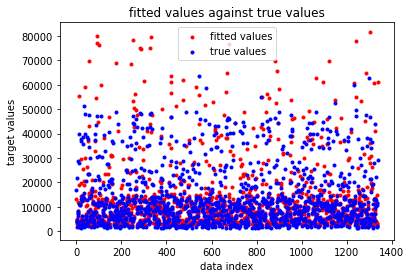

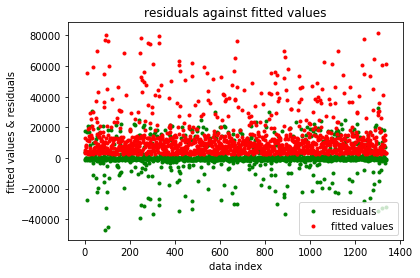

In [17]:
### 3(a)

# get the values for features and target
n_row,n_cols = insurance_df.shape
X = insurance_df.iloc[:,0:n_cols-1].values
y = insurance_df.iloc[:,n_cols-1].values


# transfer y to log(y)
y_new = np.log(y)
# use OneHotEncoder to do one hot encoding for X (that is, use the feature preprocessing method in 1a )
enc = OneHotEncoder(n_values='auto', categorical_features=[3,4,5], sparse=False, handle_unknown='error')
X_enc4 = enc.fit_transform(X)


# define a linear model and do the cross validation, report RMSE for training data and testing data
# we should calculate the difference between exp(log(y)predict) and y to set up a fair comparison
model = LinearRegression(fit_intercept=True)
kf = KFold(n_splits=10, shuffle=False, random_state=None)
train_rmse_list = []
test_rmse_list = []
for train_index, test_index in kf.split(X_enc4):                 
    X_train, y_train = X_enc4[train_index], y_new[train_index]           # training data (log(y))
    X_test, y_test = X_enc4[test_index], y_new[test_index]               # testing data  (log(y))
    model.fit(X_train,y_train)                                           # train a model with the training data
    y_train_pred = model.predict(X_train)                                # use the model we trained to predict y for training data
    y_test_pred = model.predict(X_test)                                  # use the model we trained to predict y for testing data
    train_rmse = np.sqrt(np.mean(np.square(np.exp(y_train_pred) - np.exp(y_train))))     # train_rmse 
    test_rmse = np.sqrt(np.mean(np.square(np.exp(y_test_pred) - np.exp(y_test))))        # test_rmse
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
mean_train_rmse = np.mean(train_rmse_list)
mean_test_rmse = np.mean(test_rmse_list)
print('RMSE for training data is: ', mean_train_rmse)
print('RMSE for testing data is: ', mean_test_rmse)


# train a new linear model and predict the target values using X_enc4 and y_new
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_enc4,y_new)
y_new_pred = linear_model.predict(X_enc4)


# plot
plot_target_val_and_residual(y,np.exp(y_new_pred))
#plot_target_val_and_residual(y_new,y_new_pred)

[13711.75217411 30006.41746982  1156.77113563  1340.69946323
  3696.60624649  2156.00724551] [0.00000000e+000 0.00000000e+000 3.35302212e-183 7.05906006e-204
 0.00000000e+000 4.29888592e-281]
the best two features for f_regression is: ft2 and ft1 
[1.49917138 0.06817119 0.16101784 0.17628529 0.36939335 0.07753486]
the best two features for mutual_info_regression is: ft1 and ft5 


Text(0.5, 1.0, 'charges vs. ft1')

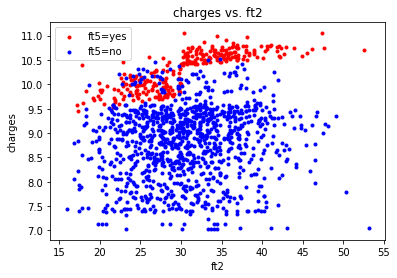

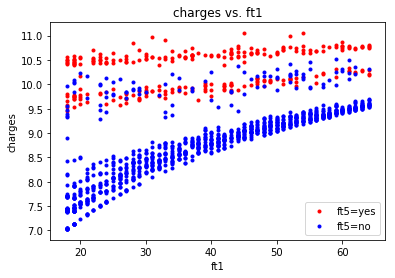

In [18]:
### 3(b)

# use f_regression to decide the two most important features
f_score_new, f_pval_new = f_regression(X,y_new,center=False)
idx_f_new = np.argsort(-f_score_new)
first_idx_f_new = idx_f_new[0]
second_idx_f_new = idx_f_new[1]
print(f_score_new,f_pval_new)
print('the best two features for f_regression is: %s and %s ' %(col_name[first_idx_f_new],col_name[second_idx_f_new]))

# use mutual_info_regression to decide the two most important features
mutual_score_new = mutual_info_regression(X, y_new, discrete_features=False, n_neighbors=3, copy=True, random_state=None)
print(mutual_score_new)
idx_m_new = np.argsort(-mutual_score_new)
first_idx_m_new = idx_m_new[0]
second_idx_m_new = idx_m_new[1]
print('the best two features for mutual_info_regression is: %s and %s ' %(col_name[first_idx_m_new],col_name[second_idx_m_new]))

# divide datas into two parts based on ft5
X_yes = X[X[:,4]==0]
y_new_yes = y_new[X[:,4]==0]
X_no = X[X[:,4]==1]
y_new_no = y_new[X[:,4]==1]

# Scatter plot charges (y axis) vs ft2 (x axis), and color points based on ft5
plt.figure()
plt.scatter(X_yes[:,1], y_new_yes, marker='.', c='r', label='ft5=yes')
plt.scatter(X_no[:,1], y_new_no, marker='.', c='b', label='ft5=no')
plt.xlabel('ft2')
plt.ylabel('charges')
plt.legend()
plt.title('charges vs. ft2')

# Scatter plot charges (y axis) vs ft1 (x axis), and color points based on ft5
plt.figure()
plt.scatter(X_yes[:,0], y_new_yes, marker='.', c='r', label='ft5=yes')
plt.scatter(X_no[:,0], y_new_no, marker='.', c='b', label='ft5=no')
plt.xlabel('ft1')
plt.ylabel('charges')
plt.legend()
plt.title('charges vs. ft1')


for degree = 1:
RMSE for training data is:  6039.342370581926
RMSE for testing data is:  6063.643882478562

for degree = 2:
RMSE for training data is:  5728.410918381174
RMSE for testing data is:  5855.987241091296

for degree = 3:
RMSE for training data is:  7050.409871408466
RMSE for testing data is:  7711.894658079864

for degree = 4:
RMSE for training data is:  4282.742056158859
RMSE for testing data is:  5739.427365591867

for degree = 5:
RMSE for training data is:  3723.480331264659
RMSE for testing data is:  10392.186973978918

for degree = 6:
RMSE for training data is:  3022.980801239834
RMSE for testing data is:  10564786.236812904


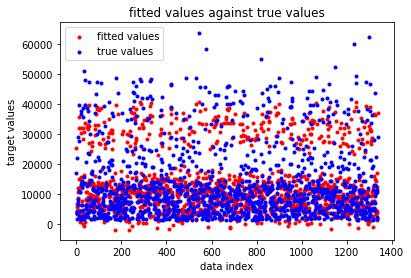

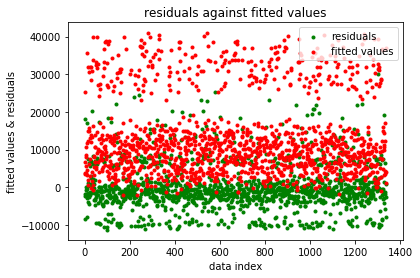

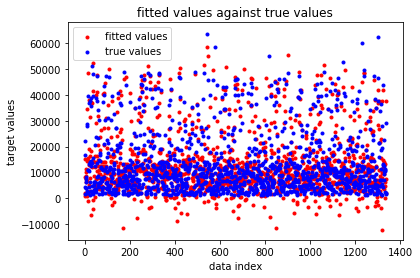

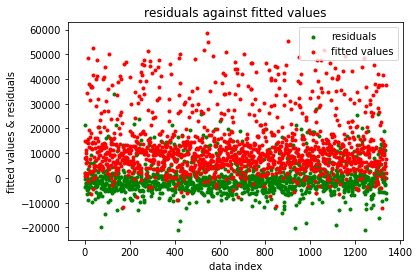

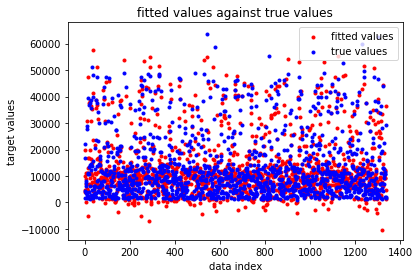

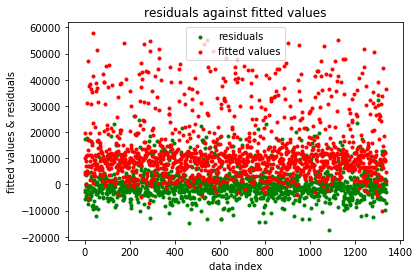

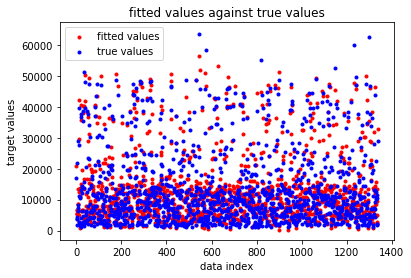

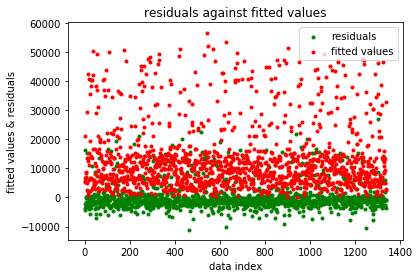

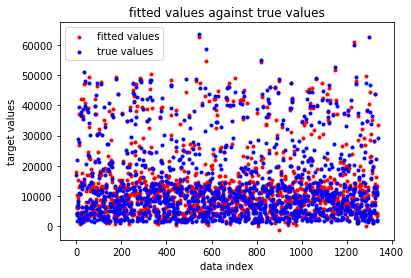

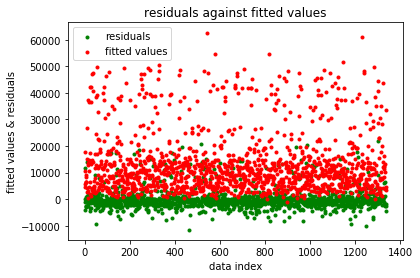

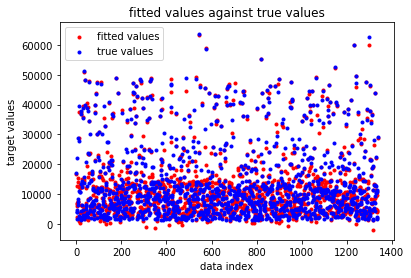

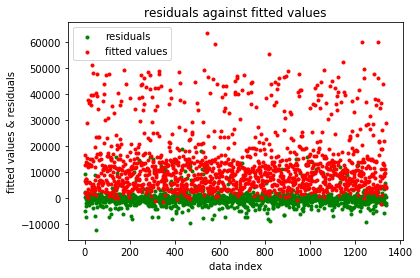

In [19]:
### 4(a) polynomial features
#(based on 1(a), use X_enc1 and y)
for degree in np.arange(1,7):
    # define polynomial features
    poly = PolynomialFeatures(degree)
    X_enc1_poly = poly.fit_transform(X_enc1)
    
    # define a linear model
    linear_model = LinearRegression(fit_intercept=True)
    
    # do the 10-fold cross validation for each degree and report the rmse
    print('\nfor degree = %s:' %degree)
    k_fold_cv_rmse(linear_model,10,X_enc1_poly,y)
    
    # use the whole dataset to train a model and plot target values and residuals
    linear_model.fit(X_enc1_poly,y)
    y_pred = linear_model.predict(X_enc1_poly)
    plot_target_val_and_residual(y,y_pred)


for num_estimator = 10, max_depth = 3:
RMSE for training data is:  4483.759439641308
RMSE for testing data is:  4610.82596056276

for num_estimator = 10, max_depth = 5:
RMSE for training data is:  4058.4356998855023
RMSE for testing data is:  4511.679978980557

for num_estimator = 10, max_depth = 7:
RMSE for training data is:  3351.4065706361243
RMSE for testing data is:  4662.639795809983

for num_estimator = 10, max_depth = 9:
RMSE for training data is:  2654.650840390031
RMSE for testing data is:  4903.330525684291

for num_estimator = 50, max_depth = 3:
RMSE for training data is:  4469.688777303151
RMSE for testing data is:  4573.635666380802

for num_estimator = 50, max_depth = 5:
RMSE for training data is:  4021.3580113306525
RMSE for testing data is:  4505.879928701777

for num_estimator = 50, max_depth = 7:
RMSE for training data is:  3259.6781117459905
RMSE for testing data is:  4582.619964447009

for num_estimator = 50, max_depth = 9:
RMSE for training data is:  2477.3559036

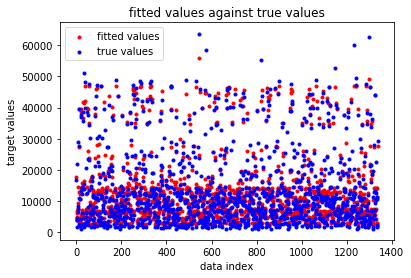

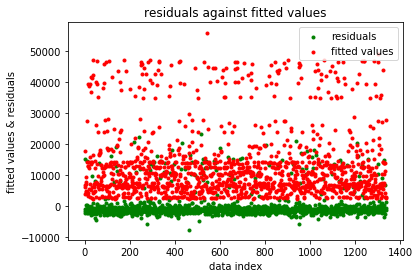

In [20]:
### 4(b) random forest
#(based on 1(a), use X_enc1 and y)

num_estimator_list = [10,50,100,300,600,1000]
max_depth_list = np.arange(3,11,2)

min_train_rmse = float('inf')
min_test_rmse = float('inf')
train_rmse_matrix = np.zeros([len(num_estimator_list),len(max_depth_list)])
test_rmse_matrix = np.zeros([len(num_estimator_list),len(max_depth_list)])

best_train_num_estimator = 0
best_test_num_estimator = 0
best_train_depth = 0
best_test_depth = 0

for i in range(len(num_estimator_list)):
    num_estimator = num_estimator_list[i]
    for j in range(len(max_depth_list)):
        depth = max_depth_list[j]
        # define a random forest regressor
        rand_forest = RandomForestRegressor(n_estimators=num_estimator, criterion='mse', 
                                            max_depth=depth, max_features='auto', 
                                            random_state=None)
        # do the 10-fold cross validation 
        print('\nfor num_estimator = %s, max_depth = %s:' %(num_estimator,depth))
        train_rmse, test_rmse = k_fold_cv_rmse(rand_forest,10,X_enc1,y)
        train_rmse_matrix[i,j] = train_rmse
        test_rmse_matrix[i,j] = test_rmse
        if train_rmse < min_train_rmse:
            min_train_rmse = train_rmse
            best_train_num_estimator = num_estimator
            best_train_depth = depth
        if test_rmse < min_test_rmse:
            min_test_rmse = test_rmse
            best_test_num_estimator = num_estimator
            best_test_depth = depth
            
print('train_rmse_matrix is :\n',train_rmse_matrix)
print('test_rmse_matrix is :\n',test_rmse_matrix)
print('the minimum train RMSE (when num_estimator = %s, max_depth = %s) is: %s'
      %(best_train_num_estimator,best_train_depth,min_train_rmse))       
print('the minimum test RMSE (when num_estimator = %s, max_depth = %s) is: %s'
      %(best_test_num_estimator,best_test_depth,min_test_rmse))   

# use the best model(with the minimum test RMSE) to train a model and plot the target values and residuals
rand_forest = RandomForestRegressor(n_estimators=best_test_num_estimator, criterion='mse', 
                                    max_depth=best_test_depth, max_features='auto', 
                                    random_state=None)
rand_forest.fit(X_enc1,y)
y_pred = rand_forest.predict(X_enc1)
plot_target_val_and_residual(y,y_pred)
print('RMSE for the whole dataset is:',np.sqrt(np.mean(np.square(y_pred - y))))

RMSE for training data is:  4784.359669795229
RMSE for testing data is:  4851.377676078211


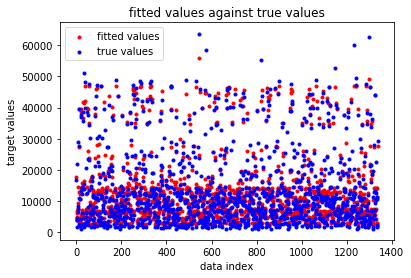

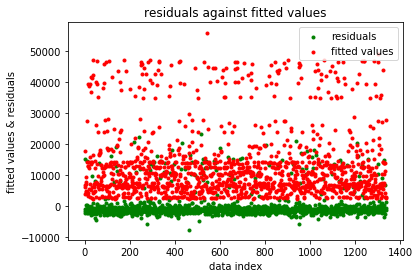

In [21]:
###   4(b) neural network
#(based on 1(a), use X_enc1 and y)

# define a random forest regressor
MLP = MLPRegressor(hidden_layer_sizes=(100,),activation='relu', solver='adam', 
                   alpha=0.0001, batch_size=800, learning_rate='constant', learning_rate_init=0.015, 
                   power_t=0.5, max_iter=3000, shuffle=True, random_state=None, tol=0.0001, verbose=False, 
                   warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                   early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
                   epsilon=1e-08)

# do the 10-fold cross validation 
train_rmse, test_rmse = k_fold_cv_rmse(MLP,10,X_enc1,y)

# use the model to train a model and plot the target values and residuals
MLP.fit(X_enc1,y)
y_pred = rand_forest.predict(X_enc1)
plot_target_val_and_residual(y,y_pred)


for num_estimator = 10, max_depth = 1:
RMSE for training data is:  8170.0128621440435
RMSE for testing data is:  8157.661852936481

for num_estimator = 10, max_depth = 2:
RMSE for training data is:  6267.875544920719
RMSE for testing data is:  6283.849652919497

for num_estimator = 10, max_depth = 3:
RMSE for training data is:  5953.721090911005
RMSE for testing data is:  6015.673367699804

for num_estimator = 10, max_depth = 4:
RMSE for training data is:  5815.186850858264
RMSE for testing data is:  5961.270009290141

for num_estimator = 10, max_depth = 5:
RMSE for training data is:  5672.672802470553
RMSE for testing data is:  5960.725846410127

for num_estimator = 50, max_depth = 1:
RMSE for training data is:  6192.880944830815
RMSE for testing data is:  6263.639690546508

for num_estimator = 50, max_depth = 2:
RMSE for training data is:  4343.466639003262
RMSE for testing data is:  4499.84713007909

for num_estimator = 50, max_depth = 3:
RMSE for training data is:  4073.7197973548

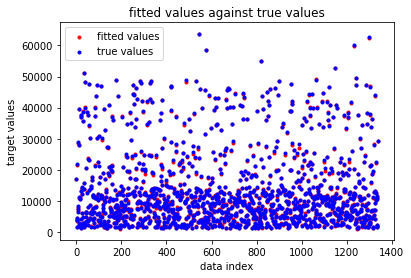

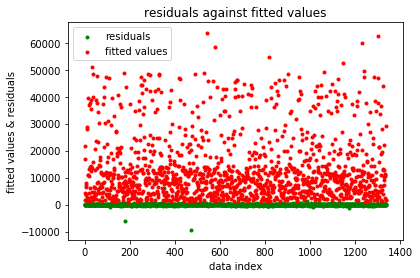

In [22]:
###   4(b) gradient boosting forest
#(based on 1(a), use X_enc1 and y)

num_estimator_list = [10,50,100,300,500,1000]
max_depth_list = np.arange(1,6)

min_train_rmse = float('inf')
min_test_rmse = float('inf')
train_rmse_matrix = np.zeros([len(num_estimator_list),len(max_depth_list)])
test_rmse_matrix = np.zeros([len(num_estimator_list),len(max_depth_list)])

best_train_num_estimator = 0
best_test_num_estimator = 0
best_train_depth = 0
best_test_depth = 0

for i in range(len(num_estimator_list)):
    num_estimator = num_estimator_list[i]
    for j in range(len(max_depth_list)):
        depth = max_depth_list[j]
        # define a random forest regressor
        grad_boosting_tree = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=num_estimator, 
                                                        max_depth=depth, random_state=None, max_features=None, alpha=0.9)
        print('\nfor num_estimator = %s, max_depth = %s:' %(num_estimator,depth))
        train_rmse, test_rmse = k_fold_cv_rmse(grad_boosting_tree,10,X_enc1,y)
        train_rmse_matrix[i,j] = train_rmse
        test_rmse_matrix[i,j] = test_rmse
        if train_rmse < min_train_rmse:
            min_train_rmse = train_rmse
            best_train_num_estimator = num_estimator
            best_train_depth = depth
        if test_rmse < min_test_rmse:
            min_test_rmse = test_rmse
            best_test_num_estimator = num_estimator
            best_test_depth = depth
            
print('train_rmse_matrix is :\n',train_rmse_matrix)
print('test_rmse_matrix is :\n',test_rmse_matrix)
print('the minimum train RMSE (when num_estimator = %s, max_depth = %s) is: %s'
      %(best_train_num_estimator,best_train_depth,min_train_rmse))       
print('the minimum test RMSE (when num_estimator = %s, max_depth = %s) is: %s'
      %(best_test_num_estimator,best_test_depth,min_test_rmse))   


# use the best model(with the minimum test RMSE) to train a model and plot the target values and residuals
grad_boostiing_tree = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=best_test_num_estimator, 
                                                max_depth=best_test_depth, random_state=None, max_features=None, alpha=0.9)
grad_boosting_tree.fit(X_enc1,y)
y_pred = grad_boosting_tree.predict(X_enc1)
plot_target_val_and_residual(y,y_pred)